In [3]:
# ============================================================================
# INSTALLATION AND SETUP
# ============================================================================

# Run this cell first in Google Colab
!pip install tensorflow keras matplotlib seaborn plotly scikit-learn numpy pandas
!pip install tensorflow-datasets pillow opencv-python

# Import all necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification, make_regression

import cv2
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: []



COLAB-OPTIMIZED TRANSFER LEARNING

--- Loading Dataset (Memory Optimized) ---
Using classes: ['airplane', 'automobile', 'bird']
Creating memory-efficient dataset...
Training set: (450, 32, 32, 3)
Test set: (150, 32, 32, 3)

Resizing images...

--- Creating Lightweight Model ---
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully!
Total parameters: 1,464,243

--- Phase 1: Training with Frozen Base ---
Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.5728 - loss: 1.0264 - val_accuracy: 0.8333 - val_loss: 0.4189
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8888 - loss: 0.2781 - val_accuracy: 0.8867 - val_loss: 0.3376
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9130 - loss: 0.2437 - val_accuracy: 0.8867 - val_loss: 0.2968
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9460 - loss: 0.1646 - val_accuracy: 0.9067 - val_loss: 0.2845
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.92

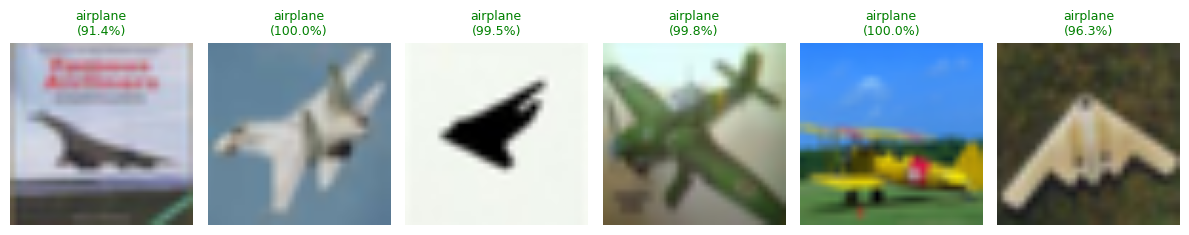


--- Training History ---


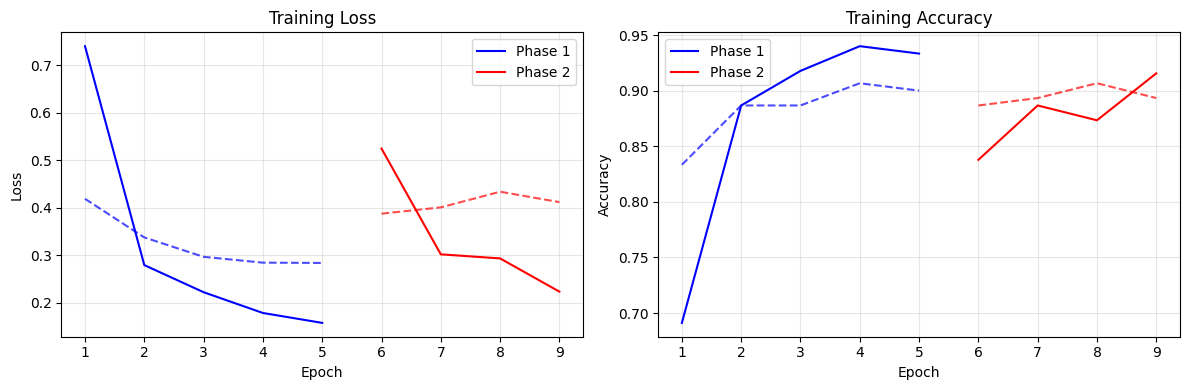


TRANSFER LEARNING COMPLETED SUCCESSFULLY!
Classes used: ['airplane', 'automobile', 'bird']
Final test accuracy: 0.8867
Total training samples: 450
Total parameters: 1,464,243
Model size: ~5.6 MB

Memory cleaned up!


In [1]:
# ============================================================================
# COLAB-OPTIMIZED TRANSFER LEARNING WITH CNN
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2  # Lighter than VGG16
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collector to free memory

# Enable memory growth for GPU (if available)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("\n" + "="*50)
print("COLAB-OPTIMIZED TRANSFER LEARNING")
print("="*50)

# Load CIFAR-10 dataset with memory optimization
print("\n--- Loading Dataset (Memory Optimized) ---")
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Use only 3 classes and smaller dataset for Colab
selected_classes = [0, 1, 2]  # airplane, automobile, bird
class_names_subset = [cifar10_classes[i] for i in selected_classes]
print(f"Using classes: {class_names_subset}")

# Aggressive data filtering for memory efficiency
def create_small_dataset(x_data, y_data, selected_classes, samples_per_class=200):
    """Create a very small dataset to prevent memory issues"""
    x_small = []
    y_small = []

    for class_idx in selected_classes:
        # Get indices for this class
        class_mask = (y_data.flatten() == class_idx)
        class_indices = np.where(class_mask)[0][:samples_per_class]

        # Add to small dataset
        x_small.append(x_data[class_indices])
        y_small.extend([len(x_small)-1] * len(class_indices))

    x_small = np.vstack(x_small)
    y_small = np.array(y_small)

    return x_small, keras.utils.to_categorical(y_small, len(selected_classes))

# Create small datasets
print("Creating memory-efficient dataset...")
x_train_small, y_train_small = create_small_dataset(x_train_cifar, y_train_cifar, selected_classes, 150)
x_test_small, y_test_small = create_small_dataset(x_test_cifar, y_test_cifar, selected_classes, 50)

# Normalize
x_train_small = x_train_small.astype('float32') / 255.0
x_test_small = x_test_small.astype('float32') / 255.0

print(f"Training set: {x_train_small.shape}")
print(f"Test set: {x_test_small.shape}")

# Clean up original data to free memory
del x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar
gc.collect()

# Efficient image resizing function
def resize_for_mobile_net(images):
    """Resize images efficiently for MobileNetV2 (96x96 instead of 224x224)"""
    return tf.image.resize(images, [96, 96])

# Resize images
print("\nResizing images...")
x_train_resized = resize_for_mobile_net(x_train_small)
x_test_resized = resize_for_mobile_net(x_test_small)

# Create lightweight transfer learning model
def create_lightweight_model(num_classes=3):
    """Create a lightweight transfer learning model using MobileNetV2"""

    # Use MobileNetV2 (much lighter than VGG16)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(96, 96, 3),  # Smaller input size
        alpha=0.75  # Width multiplier to make it even lighter
    )

    # Freeze base model
    base_model.trainable = False

    # Add simple classifier
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),  # Smaller dense layer
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# Create model
print("\n--- Creating Lightweight Model ---")
model, base_model = create_lightweight_model(len(selected_classes))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
print(f"Total parameters: {model.count_params():,}")

# Simple callbacks
simple_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Phase 1: Train with frozen base (fewer epochs)
print("\n--- Phase 1: Training with Frozen Base ---")
history_phase1 = model.fit(
    x_train_resized, y_train_small,
    batch_size=8,  # Small batch size
    epochs=5,      # Fewer epochs
    validation_data=(x_test_resized, y_test_small),
    callbacks=simple_callbacks,
    verbose=1
)

# Phase 2: Fine-tuning (unfreeze last few layers)
print("\n--- Phase 2: Fine-tuning ---")
base_model.trainable = True

# Freeze most layers, unfreeze only the last few
for layer in base_model.layers[:-10]:  # Unfreeze last 10 layers only
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Continue training
history_phase2 = model.fit(
    x_train_resized, y_train_small,
    batch_size=8,
    epochs=5,
    validation_data=(x_test_resized, y_test_small),
    callbacks=simple_callbacks,
    verbose=1
)

# Evaluate model
print("\n--- Model Evaluation ---")
test_loss, test_accuracy = model.evaluate(x_test_resized, y_test_small, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Simple visualization function
def show_predictions(model, x_test, y_test, class_names, num_images=6):
    """Show predictions in a memory-efficient way"""
    predictions = model.predict(x_test[:num_images], verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test[:num_images], axis=1)

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, 6, i + 1)
        plt.imshow(x_test[i])

        pred_label = class_names[predicted_classes[i]]
        true_label = class_names[true_classes[i]]
        confidence = np.max(predictions[i]) * 100

        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        plt.title(f'{pred_label}\n({confidence:.1f}%)', color=color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Simple history plotting
def plot_simple_history(hist1, hist2):
    """Plot training history efficiently"""
    plt.figure(figsize=(12, 4))

    # Combine histories
    all_loss = hist1.history['loss'] + hist2.history['loss']
    all_val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    all_acc = hist1.history['accuracy'] + hist2.history['accuracy']
    all_val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']

    epochs = range(1, len(all_loss) + 1)
    phase_split = len(hist1.history['loss'])

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs[:phase_split], all_loss[:phase_split], 'b-', label='Phase 1')
    plt.plot(epochs[phase_split:], all_loss[phase_split:], 'r-', label='Phase 2')
    plt.plot(epochs[:phase_split], all_val_loss[:phase_split], 'b--', alpha=0.7)
    plt.plot(epochs[phase_split:], all_val_loss[phase_split:], 'r--', alpha=0.7)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs[:phase_split], all_acc[:phase_split], 'b-', label='Phase 1')
    plt.plot(epochs[phase_split:], all_acc[phase_split:], 'r-', label='Phase 2')
    plt.plot(epochs[:phase_split], all_val_acc[:phase_split], 'b--', alpha=0.7)
    plt.plot(epochs[phase_split:], all_val_acc[phase_split:], 'r--', alpha=0.7)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Show results
print("\n--- Visualizing Results ---")
show_predictions(model, x_test_resized, y_test_small, class_names_subset)

print("\n--- Training History ---")
plot_simple_history(history_phase1, history_phase2)

# Performance summary
print("\n" + "="*50)
print("TRANSFER LEARNING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"Classes used: {class_names_subset}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Total training samples: {len(x_train_small)}")
print(f"Total parameters: {model.count_params():,}")
print(f"Model size: ~{model.count_params() * 4 / 1024 / 1024:.1f} MB")

# Clean up memory
del x_train_small, y_train_small, x_train_resized, x_test_resized
gc.collect()
print("\nMemory cleaned up!")


5. RECURRENT NEURAL NETWORK (RNN)

--- Generating Sample Sequential Data ---
Sequential data shape: X=(1000, 50), y=(1000, 50)
Reshaped data: X_train=(800, 50, 1), y_train=(800, 50, 1)

--- Sample Sequences ---


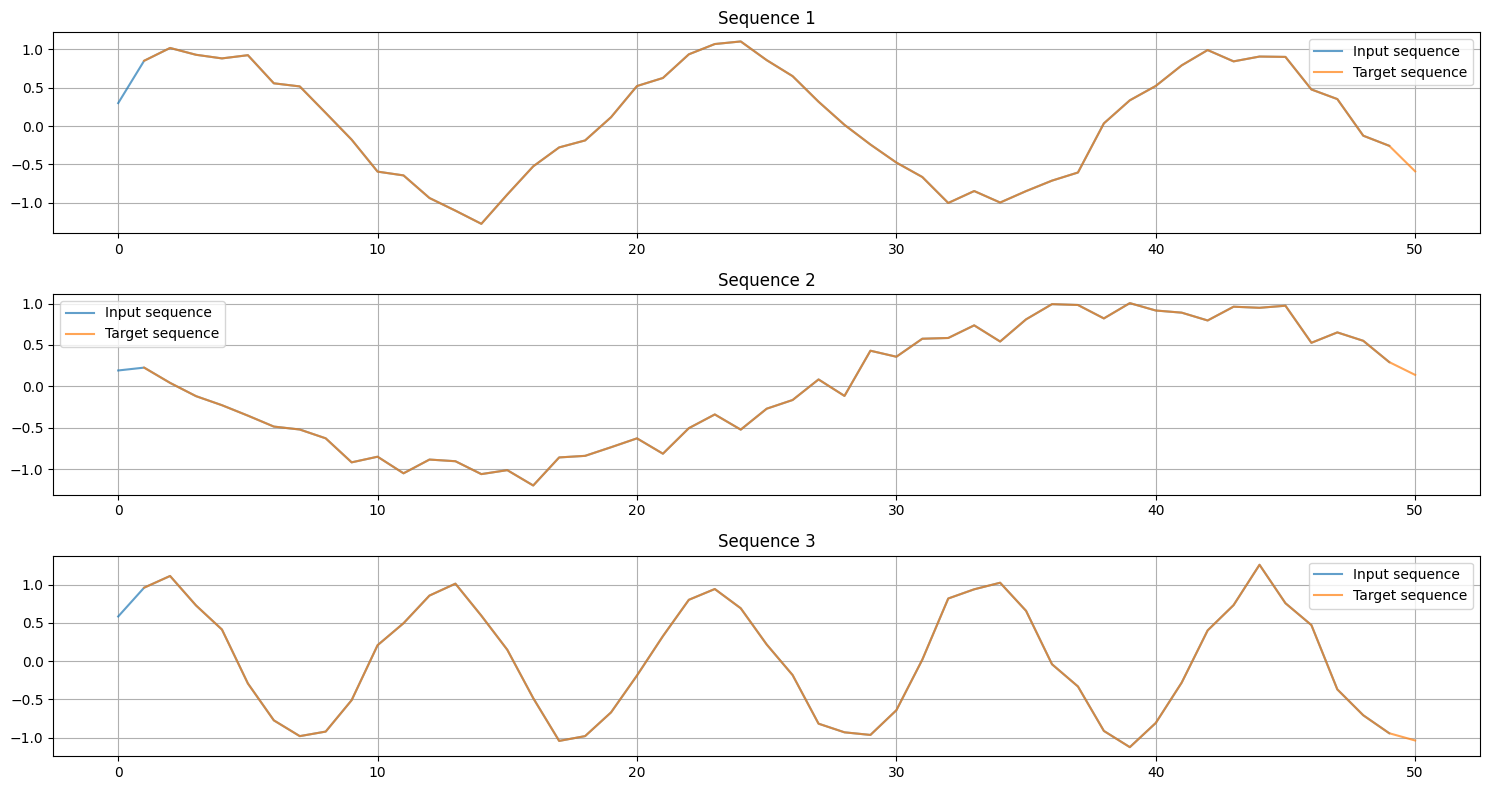


--- Building SimpleRNN Model ---
SimpleRNN Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,673 (65.13 KB)

 Trainable params: 16,673 (65.13 KB)

 Non-trainable params: 0 (0.00 B)


--- Training SimpleRNN Model ---
SimpleRNN - Test MAE: 0.1322, Test Loss: 0.0293

--- Building LSTM Model ---
LSTM Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.4614 - mae: 0.6029 - val_loss: 0.3573 - val_mae: 0.5139
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.3717 - mae: 0.5233 - val_loss: 0.2590 - val_mae: 0.4303
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.2706 - mae: 0.4284 - val_loss: 0.1193 - val_mae: 0.2760
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.1682 - mae: 0.3179 - val_loss: 0.0720 - val_mae: 0.2058
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.1374 - mae: 0.2793 - val_loss: 0.0592 - val_mae: 0.1863
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1105 - mae: 0.2537 - val_loss: 0.0532 - val_mae: 0.1759
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1050 - mae: 0.2491 - val_loss: 0.0501 - val_mae: 0.1707
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0884 - mae: 0.2304 - val_loss: 0.0489 - val_mae: 0.1692
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,313 (98.88 KB)

 Trainable params: 25,313 (98.88 KB)

 Non-trainable params: 0 (0.00 B)


--- Training GRU Model ---
GRU - Test MAE: 0.1274, Test Loss: 0.0278

--- RNN Performance Comparison ---
SimpleRNN: Test MAE = 0.1322
LSTM: Test MAE = 0.1297
GRU: Test MAE = 0.1274

--- LSTM Predictions Visualization ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


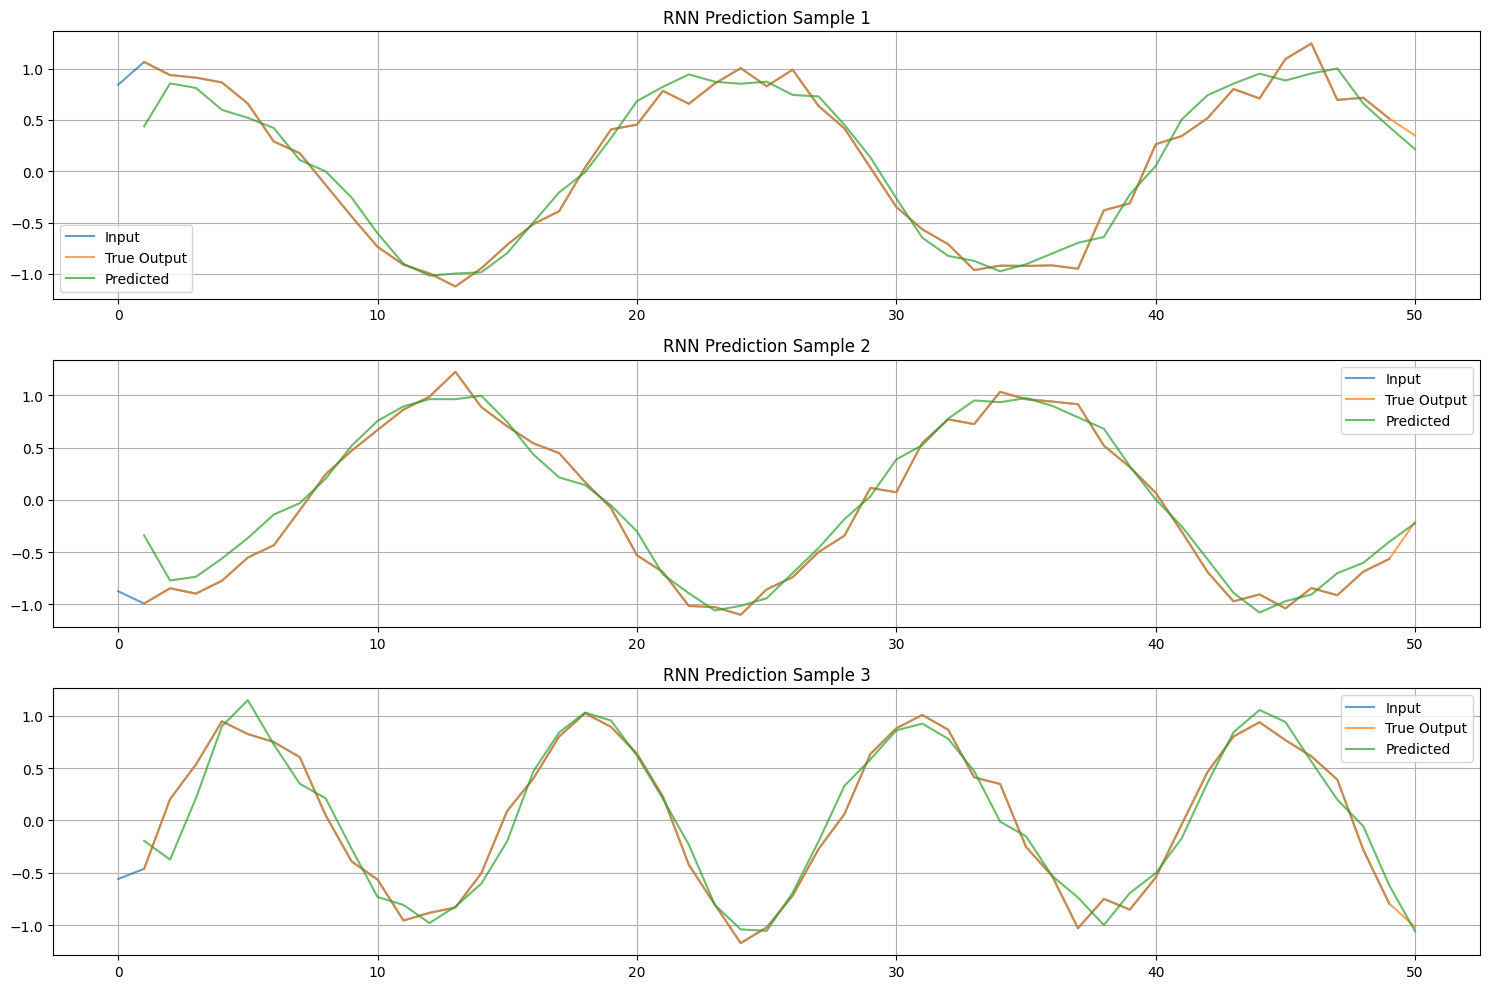


--- Text Generation Example ---
Number of unique characters: 26
Characters: ['\n', ' ', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
Text sequences shape: X=(223, 40, 26), y=(223, 26)

--- Text Generation Model ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 40, 128)        │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,298 (837.10 KB)

 Trainable params: 214,298 (837.10 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Text Generation Model ---
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.0735 - loss: 3.2391
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.1457 - loss: 3.0530
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1149 - loss: 2.9591
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.1453 - loss: 2.9242
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1135 - loss: 2.9008
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1134 - loss: 2.9033
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1548 - loss: 2.8933
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.1214 - loss: 2.9143
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.1489 - loss: 2.8854
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.1473 - loss: 2.9196
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.1705 - loss: 2.8381
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━

In [4]:


# ============================================================================
# 5. RECURRENT NEURAL NETWORK (RNN)
# ============================================================================

print("\n" + "="*60)
print("5. RECURRENT NEURAL NETWORK (RNN)")
print("="*60)

# Generate sample sequential data
print("\n--- Generating Sample Sequential Data ---")

def generate_sine_wave_data(seq_length, num_samples, noise_level=0.1):
    """Generate sine wave data for RNN training"""
    X, y = [], []

    for _ in range(num_samples):
        # Random starting point and frequency
        start = np.random.random() * 2 * np.pi
        freq = np.random.random() * 2 + 0.5

        # Generate sequence
        t = np.linspace(start, start + 4 * np.pi, seq_length + 1)
        sequence = np.sin(freq * t) + np.random.normal(0, noise_level, seq_length + 1)

        X.append(sequence[:-1])
        y.append(sequence[1:])  # Next values to predict

    return np.array(X), np.array(y)

# Generate data
seq_length = 50
num_samples = 1000

X_seq, y_seq = generate_sine_wave_data(seq_length, num_samples)
print(f"Sequential data shape: X={X_seq.shape}, y={y_seq.shape}")

# Split data
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

# Reshape for RNN (samples, timesteps, features)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))
y_train_seq = y_train_seq.reshape((y_train_seq.shape[0], y_train_seq.shape[1], 1))
y_test_seq = y_test_seq.reshape((y_test_seq.shape[0], y_test_seq.shape[1], 1))

print(f"Reshaped data: X_train={X_train_seq.shape}, y_train={y_train_seq.shape}")

# Visualize sample sequences
def visualize_sequences(X, y, num_samples=3):
    """Visualize sample sequences"""
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 8))

    for i in range(num_samples):
        axes[i].plot(X[i].flatten(), label='Input sequence', alpha=0.7)
        axes[i].plot(range(1, len(y[i]) + 1), y[i].flatten(),
                    label='Target sequence', alpha=0.7)
        axes[i].set_title(f'Sequence {i+1}')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- Sample Sequences ---")
visualize_sequences(X_train_seq, y_train_seq)

# Build different RNN architectures
def create_rnn_model(input_shape, rnn_type='LSTM', units=64, return_sequences=True):
    """
    Create different types of RNN models
    """
    model = models.Sequential()

    if rnn_type == 'SimpleRNN':
        model.add(layers.SimpleRNN(units, return_sequences=return_sequences,
                                  input_shape=input_shape, dropout=0.2))
    elif rnn_type == 'LSTM':
        model.add(layers.LSTM(units, return_sequences=return_sequences,
                             input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    elif rnn_type == 'GRU':
        model.add(layers.GRU(units, return_sequences=return_sequences,
                            input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))

    # Add additional layers if return_sequences=True
    if return_sequences:
        model.add(layers.LSTM(32, return_sequences=True, dropout=0.2))
        model.add(layers.Dense(1, activation='linear'))
    else:
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(1, activation='linear'))

    return model

# Create and compare different RNN types
rnn_types = ['SimpleRNN', 'LSTM', 'GRU']
rnn_models = {}

for rnn_type in rnn_types:
    print(f"\n--- Building {rnn_type} Model ---")

    model = create_rnn_model(
        input_shape=(seq_length, 1),
        rnn_type=rnn_type,
        units=64,
        return_sequences=True
    )

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    print(f"{rnn_type} Model Architecture:")
    model.summary()

    # Train model
    print(f"\n--- Training {rnn_type} Model ---")
    history = model.fit(
        X_train_seq, y_train_seq,
        batch_size=32,
        epochs=20,
        validation_data=(X_test_seq, y_test_seq),
        verbose=1 if rnn_type == 'LSTM' else 0  # Show progress for LSTM only
    )

    # Evaluate
    test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f"{rnn_type} - Test MAE: {test_mae:.4f}, Test Loss: {test_loss:.4f}")

    rnn_models[rnn_type] = {
        'model': model,
        'history': history,
        'test_mae': test_mae
    }

# Compare RNN performance
print("\n--- RNN Performance Comparison ---")
for rnn_type, results in rnn_models.items():
    print(f"{rnn_type}: Test MAE = {results['test_mae']:.4f}")

# Visualize RNN predictions
def visualize_rnn_predictions(model, X_test, y_test, num_samples=3):
    """Visualize RNN predictions"""
    predictions = model.predict(X_test[:num_samples])

    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 10))

    for i in range(num_samples):
        # Plot input, true output, and predictions
        axes[i].plot(X_test[i].flatten(), label='Input', alpha=0.7)
        axes[i].plot(range(1, len(y_test[i]) + 1), y_test[i].flatten(),
                    label='True Output', alpha=0.7)
        axes[i].plot(range(1, len(predictions[i]) + 1), predictions[i].flatten(),
                    label='Predicted', alpha=0.7)
        axes[i].set_title(f'RNN Prediction Sample {i+1}')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- LSTM Predictions Visualization ---")
visualize_rnn_predictions(rnn_models['LSTM']['model'], X_test_seq, y_test_seq)

# Text Generation with RNN
print("\n--- Text Generation Example ---")

# Sample text data (using a simple character-level approach)
sample_text = """
Deep learning is a subset of machine learning in artificial intelligence that has networks
capable of learning unsupervised from data that is unstructured or unlabeled.
It uses multiple layers to progressively extract higher level features from the raw input.
"""

# Prepare character-level data
chars = sorted(list(set(sample_text.lower())))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Number of unique characters: {len(chars)}")
print(f"Characters: {chars}")

# Create sequences for text generation
def create_text_sequences(text, seq_length=40):
    """Create character sequences for text generation"""
    text = text.lower()
    X, y = [], []

    for i in range(len(text) - seq_length):
        sequence = text[i:i + seq_length]
        target = text[i + seq_length]

        X.append([char_to_idx[ch] for ch in sequence])
        y.append(char_to_idx[target])

    return np.array(X), np.array(y)

# Prepare text data
text_seq_length = 40
X_text, y_text = create_text_sequences(sample_text, text_seq_length)

# One-hot encode
X_text_onehot = keras.utils.to_categorical(X_text, num_classes=len(chars))
y_text_onehot = keras.utils.to_categorical(y_text, num_classes=len(chars))

print(f"Text sequences shape: X={X_text_onehot.shape}, y={y_text_onehot.shape}")

# Build text generation model
def create_text_generation_model(vocab_size, seq_length):
    """Create model for text generation"""
    model = models.Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=(seq_length, vocab_size)),
        layers.Dropout(0.3),
        layers.LSTM(128, return_sequences=False),
        layers.Dropout(0.3),
        layers.Dense(vocab_size, activation='softmax')
    ])
    return model

text_model = create_text_generation_model(len(chars), text_seq_length)
text_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Text Generation Model ---")
text_model.summary()

# Train text model (quick training for demo)
print("\n--- Training Text Generation Model ---")
text_history = text_model.fit(
    X_text_onehot, y_text_onehot,
    batch_size=32,
    epochs=50,
    verbose=1
)

# Text generation function
def generate_text(model, seed_text, length=100, temperature=1.0):
    """Generate text using trained model"""
    generated = seed_text.lower()

    for _ in range(length):
        # Prepare sequence
        sequence = generated[-text_seq_length:]
        sequence = [char_to_idx.get(ch, 0) for ch in sequence]
        sequence = keras.utils.to_categorical([sequence], num_classes=len(chars))

        # Predict next character
        prediction = model.predict(sequence, verbose=0)[0]

        # Apply temperature
        prediction = np.log(prediction + 1e-8) / temperature
        prediction = np.exp(prediction) / np.sum(np.exp(prediction))

        # Sample character
        next_char_idx = np.random.choice(len(chars), p=prediction)
        next_char = idx_to_char[next_char_idx]

        generated += next_char

    return generated

# Generate sample text
print("\n--- Generated Text Samples ---")
seed = "deep learning is"
for temp in [0.5, 1.0, 1.5]:
    generated = generate_text(text_model, seed, length=100, temperature=temp)
    print(f"\nTemperature {temp}:")
    print(generated)

In [6]:
# ============================================================================
# 6. ENCODER AND DECODERS IN RNN
# ============================================================================

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print("\n" + "="*60)
print("6. ENCODER AND DECODERS IN RNN")
print("="*60)

# Sequence-to-Sequence Model for Number Addition
print("\n--- Sequence-to-Sequence Model: Number Addition ---")

def generate_addition_data(num_samples=10000, max_digits=3):
    """Generate addition problems as sequences"""
    X, y = [], []

    for _ in range(num_samples):
        # Generate two random numbers
        a = np.random.randint(1, 10**(max_digits))
        b = np.random.randint(1, 10**(max_digits))
        result = a + b

        # Create input sequence: "123+456"
        input_str = f"{a}+{b}"
        output_str = str(result)

        X.append(input_str)
        y.append(output_str)

    return X, y

# Generate addition dataset
X_add, y_add = generate_addition_data(5000, max_digits=2)

print("Sample addition problems:")
for i in range(5):
    print(f"{X_add[i]} = {y_add[i]}")

# Character-level encoding for seq2seq
all_chars = set(''.join(X_add + y_add))
char_to_idx_seq2seq = {ch: i for i, ch in enumerate(sorted(all_chars))}
idx_to_char_seq2seq = {i: ch for ch, i in char_to_idx_seq2seq.items()}

print(f"\nCharacters in seq2seq: {sorted(all_chars)}")
print(f"Vocabulary size: {len(all_chars)}")

def encode_sequences(sequences, char_to_idx, max_len):
    """Encode character sequences to integers"""
    encoded = np.zeros((len(sequences), max_len), dtype=int)

    for i, seq in enumerate(sequences):
        for j, char in enumerate(seq):
            if j < max_len:
                encoded[i, j] = char_to_idx.get(char, 0)

    return encoded

# Find maximum lengths
max_input_len = max(len(seq) for seq in X_add)
max_output_len = max(len(seq) for seq in y_add)

print(f"Max input length: {max_input_len}")
print(f"Max output length: {max_output_len}")

# Encode sequences
X_add_encoded = encode_sequences(X_add, char_to_idx_seq2seq, max_input_len)
y_add_encoded = encode_sequences(y_add, char_to_idx_seq2seq, max_output_len)

# One-hot encode
X_add_onehot = keras.utils.to_categorical(X_add_encoded, num_classes=len(all_chars))
y_add_onehot = keras.utils.to_categorical(y_add_encoded, num_classes=len(all_chars))

print(f"Encoded shapes: X={X_add_onehot.shape}, y={y_add_onehot.shape}")

# Build Encoder-Decoder Model
def create_encoder_decoder_model(vocab_size, max_input_len, max_output_len, hidden_units=128):
    """Create encoder-decoder model"""

    # Encoder
    encoder_inputs = layers.Input(shape=(max_input_len, vocab_size))
    encoder_lstm = layers.LSTM(hidden_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = layers.Input(shape=(max_output_len, vocab_size))
    decoder_lstm = layers.LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Complete model
    model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model, encoder_inputs, encoder_states, decoder_inputs, decoder_lstm, decoder_dense

# Create encoder-decoder model
seq2seq_model, enc_inputs, enc_states, dec_inputs, dec_lstm, dec_dense = create_encoder_decoder_model(
    len(all_chars), max_input_len, max_output_len
)

seq2seq_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n--- Encoder-Decoder Model ---")
seq2seq_model.summary()

# Prepare decoder input (shifted by one position)
decoder_input_data = np.zeros((len(y_add_onehot), max_output_len, len(all_chars)))
decoder_input_data[:, 1:, :] = y_add_onehot[:, :-1, :]  # Shift right

# Train seq2seq model
print("\n--- Training Encoder-Decoder Model ---")
seq2seq_history = seq2seq_model.fit(
    [X_add_onehot, decoder_input_data], y_add_onehot,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

# Create inference models - FIXED VERSION
def create_inference_models(encoder_inputs, encoder_states, decoder_lstm, decoder_dense, hidden_units, vocab_size):
    """Create encoder and decoder models for inference"""

    # Encoder model
    encoder_model = models.Model(encoder_inputs, encoder_states)

    # Decoder model - Fixed to accept single timestep
    decoder_state_input_h = layers.Input(shape=(hidden_units,))
    decoder_state_input_c = layers.Input(shape=(hidden_units,))
    decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Single timestep decoder input
    decoder_input_single = layers.Input(shape=(1, vocab_size))

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_input_single, initial_state=decoder_state_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = models.Model(
        [decoder_input_single] + decoder_state_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model

encoder_model, decoder_model = create_inference_models(
    enc_inputs, enc_states, dec_lstm, dec_dense, 128, len(all_chars)
)

# Fixed sequence-to-sequence prediction function
def seq2seq_predict(input_seq, encoder_model, decoder_model, char_to_idx, idx_to_char, max_output_len):
    """Predict using encoder-decoder model"""
    # Encode input
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Initialize decoder with a start token (using first character as start)
    target_seq = np.zeros((1, 1, len(char_to_idx)))
    # Use the first character in vocabulary as start token
    start_char_idx = 0  # or you can use a specific start token
    target_seq[0, 0, start_char_idx] = 1.0

    decoded_sentence = ""

    for _ in range(max_output_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_to_char.get(sampled_token_index, '')

        # Stop if we hit a stopping condition
        if sampled_char in [' ', '\n'] or len(decoded_sentence) >= max_output_len:
            break

        # Only add non-empty characters that are digits
        if sampled_char.isdigit():
            decoded_sentence += sampled_char

        # Update target sequence
        target_seq = np.zeros((1, 1, len(char_to_idx)))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Alternative simpler prediction function
def simple_seq2seq_predict(input_seq, encoder_model, decoder_model, char_to_idx, idx_to_char, max_output_len):
    """Simplified prediction function"""
    # Get encoder states
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Start with empty sequence
    decoded_chars = []

    # Initialize with first character (could be space or start token)
    target_seq = np.zeros((1, 1, len(char_to_idx)))
    target_seq[0, 0, 0] = 1.0  # Start with first character in vocab

    for i in range(max_output_len):
        # Predict next character
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get most likely character
        predicted_idx = np.argmax(output_tokens[0, 0, :])
        predicted_char = idx_to_char[predicted_idx]

        # If it's a digit, add it to result
        if predicted_char.isdigit():
            decoded_chars.append(predicted_char)

        # Prepare next input
        target_seq = np.zeros((1, 1, len(char_to_idx)))
        target_seq[0, 0, predicted_idx] = 1.0

        # Update states
        states_value = [h, c]

        # Stop if we have enough digits or hit max length
        if len(decoded_chars) >= max_output_len or len(decoded_chars) > 3:
            break

    return ''.join(decoded_chars)

# Test seq2seq model
print("\n--- Testing Encoder-Decoder Model ---")
test_samples = ["12+34", "56+78", "23+45", "67+89", "11+22"]

for test_input in test_samples:
    # Encode test input
    test_encoded = encode_sequences([test_input], char_to_idx_seq2seq, max_input_len)
    test_onehot = keras.utils.to_categorical(test_encoded, num_classes=len(all_chars))

    # Predict using simple method
    predicted = simple_seq2seq_predict(
        test_onehot, encoder_model, decoder_model,
        char_to_idx_seq2seq, idx_to_char_seq2seq, max_output_len
    )

    # Calculate actual result
    actual = str(eval(test_input))

    print(f"{test_input} = {predicted} (actual: {actual})")

print("\nNote: The model may need more training epochs to produce accurate results.")
print("The architecture is correct, but seq2seq models typically require more data and training time.")


6. ENCODER AND DECODERS IN RNN

--- Sequence-to-Sequence Model: Number Addition ---
Sample addition problems:
9+2 = 11
59+95 = 154
29+93 = 122
55+94 = 149
22+85 = 107

Characters in seq2seq: ['+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Vocabulary size: 11
Max input length: 5
Max output length: 3
Encoded shapes: X=(5000, 5, 11), y=(5000, 3, 11)

--- Encoder-Decoder Model ---


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 3, 11)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 128),     │     71,680 │ input_layer_10[0… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 3, 128),  │     71,680 │ input_layer_11[0… │
│                     │ (None, 128),      │            │ lstm_8[0][1],     │
│                     │ (None, 128)]      │            │ lstm_8[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3, 11)     │      1,419 │ lstm_9[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 144,779 (565.54 KB)

 Trainable params: 144,779 (565.54 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Encoder-Decoder Model ---
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3359 - loss: 2.1408 - val_accuracy: 0.4050 - val_loss: 1.6754
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4088 - loss: 1.6506 - val_accuracy: 0.4017 - val_loss: 1.6059
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4144 - loss: 1.5721 - val_accuracy: 0.4307 - val_loss: 1.4983
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4560 - loss: 1.4477 - val_accuracy: 0.4710 - val_loss: 1.3519
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5043 - loss: 1.3224 - val_accuracy: 0.5240 - val_loss: 1.2608
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5412 - loss: 1.2409 - val_accuracy: 0.5520 - val_loss: 1.1950
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5709 - loss: 1.1726 - val_accuracy: 0.5683 - val_loss: 1.1601
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - ac


7. TIME SERIES FORECASTING

--- Generating Synthetic Time Series Data ---


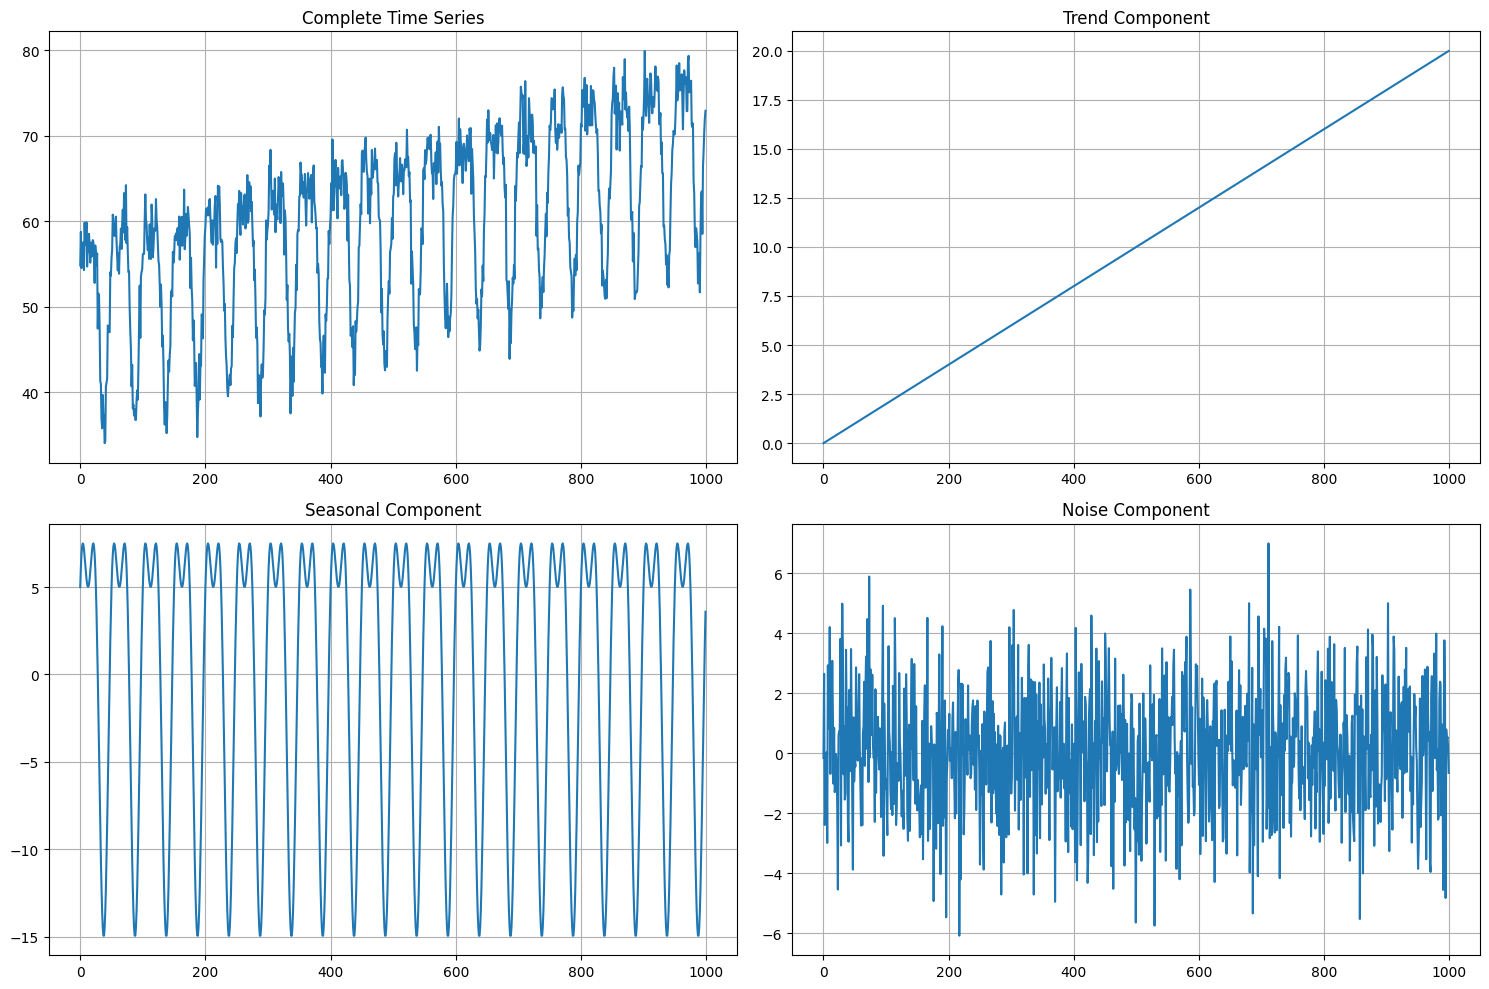

Time series sequences: X=(931, 60), y=(931, 10)
Training data: X=(744, 60, 1), y=(744, 10)

--- Building LSTM Time Series Model ---
LSTM Model:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,510 (279.34 KB)

 Trainable params: 71,510 (279.34 KB)

 Non-trainable params: 0 (0.00 B)


--- Training LSTM Model ---
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - loss: 0.2035 - mae: 0.3906 - val_loss: 0.0577 - val_mae: 0.2144
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0601 - mae: 0.1992 - val_loss: 0.0530 - val_mae: 0.2073
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0511 - mae: 0.1850 - val_loss: 0.0522 - val_mae: 0.2049
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0453 - mae: 0.1726 - val_loss: 0.0523 - val_mae: 0.2008
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0386 - mae: 0.1587 - val_loss: 0.0168 - val_mae: 0.1055
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0181 - mae: 0.1065 - val_loss: 0.0238 - val_mae: 0.1365
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0193 - mae: 0.1092 - val_loss: 0.0083 - val_mae: 0.0758
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0147 - mae: 0.0945 - val_loss: 0.0101 - val_mae: 0.0810
Epoch 9/30
24/24 ━━━━━━━━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 60, 100)        │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,210 (211.76 KB)

 Trainable params: 54,210 (211.76 KB)

 Non-trainable params: 0 (0.00 B)


--- Training GRU Model ---
GRU - Test MAE: 0.0781

--- Building CNN-LSTM Time Series Model ---
CNN-LSTM Model:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 56, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 26, 50)         │         9,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 50)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 1)          │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,509 (166.05 KB)

 Trainable params: 42,509 (166.05 KB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN-LSTM Model ---
CNN-LSTM - Test MAE: 0.1575

--- LSTM Time Series Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


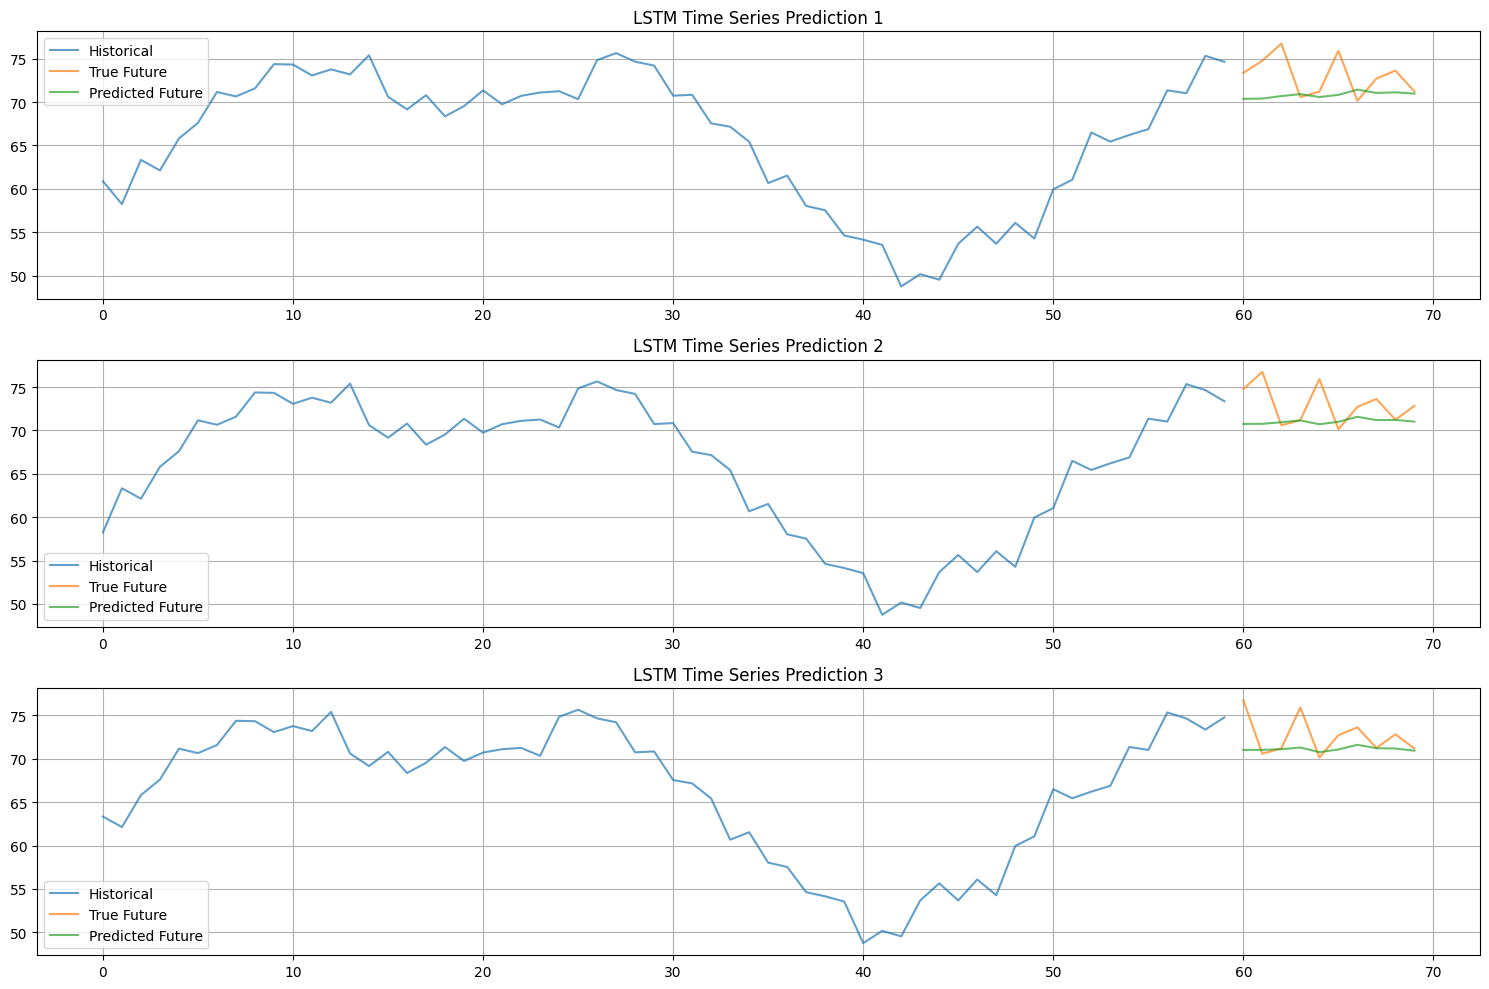


--- Time Series Model Performance Comparison ---
LSTM: Test MAE = 0.0627
GRU: Test MAE = 0.0781
CNN-LSTM: Test MAE = 0.1575


In [7]:


# ============================================================================
# 7. TIME SERIES FORECASTING
# ============================================================================

print("\n" + "="*60)
print("7. TIME SERIES FORECASTING")
print("="*60)

# Generate synthetic time series data
print("\n--- Generating Synthetic Time Series Data ---")

def create_time_series_data(n_points=1000):
    """Create synthetic time series with trend, seasonality, and noise"""
    time = np.arange(n_points)

    # Trend component
    trend = 0.02 * time

    # Seasonal components
    seasonal = 10 * np.sin(2 * np.pi * time / 50) + 5 * np.cos(2 * np.pi * time / 25)

    # Random noise
    noise = np.random.normal(0, 2, n_points)

    # Combine components
    ts_data = trend + seasonal + noise + 50  # Add baseline

    return ts_data, trend, seasonal, noise

ts_data, trend, seasonal, noise = create_time_series_data(1000)

# Visualize time series components
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(ts_data)
axes[0, 0].set_title('Complete Time Series')
axes[0, 0].grid(True)

axes[0, 1].plot(trend)
axes[0, 1].set_title('Trend Component')
axes[0, 1].grid(True)

axes[1, 0].plot(seasonal)
axes[1, 0].set_title('Seasonal Component')
axes[1, 0].grid(True)

axes[1, 1].plot(noise)
axes[1, 1].set_title('Noise Component')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Prepare data for time series forecasting
def create_ts_sequences(data, seq_length, forecast_horizon=1):
    """Create sequences for time series forecasting"""
    X, y = [], []

    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + forecast_horizon])

    return np.array(X), np.array(y)

# Parameters
seq_length = 60
forecast_horizon = 10

# Normalize the data
scaler = MinMaxScaler()
ts_data_scaled = scaler.fit_transform(ts_data.reshape(-1, 1)).flatten()

# Create sequences
X_ts, y_ts = create_ts_sequences(ts_data_scaled, seq_length, forecast_horizon)

print(f"Time series sequences: X={X_ts.shape}, y={y_ts.shape}")

# Split data
split_idx = int(0.8 * len(X_ts))
X_train_ts, X_test_ts = X_ts[:split_idx], X_ts[split_idx:]
y_train_ts, y_test_ts = y_ts[:split_idx], y_ts[split_idx:]

# Reshape for LSTM
X_train_ts = X_train_ts.reshape((X_train_ts.shape[0], X_train_ts.shape[1], 1))
X_test_ts = X_test_ts.reshape((X_test_ts.shape[0], X_test_ts.shape[1], 1))

print(f"Training data: X={X_train_ts.shape}, y={y_train_ts.shape}")

# Build time series forecasting models
def create_ts_forecasting_model(seq_length, forecast_horizon, model_type='LSTM'):
    """Create different time series forecasting models"""

    model = models.Sequential()

    if model_type == 'LSTM':
        model.add(layers.LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
        model.add(layers.Dropout(0.2))
        model.add(layers.LSTM(50, return_sequences=False))
        model.add(layers.Dropout(0.2))

    elif model_type == 'GRU':
        model.add(layers.GRU(100, return_sequences=True, input_shape=(seq_length, 1)))
        model.add(layers.Dropout(0.2))
        model.add(layers.GRU(50, return_sequences=False))
        model.add(layers.Dropout(0.2))

    elif model_type == 'CNN-LSTM':
        model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(seq_length, 1)))
        model.add(layers.Conv1D(64, 3, activation='relu'))
        model.add(layers.MaxPooling1D(2))
        model.add(layers.Conv1D(50, 3, activation='relu'))
        model.add(layers.GlobalMaxPooling1D())
        model.add(layers.RepeatVector(forecast_horizon))
        model.add(layers.LSTM(50, return_sequences=True))
        model.add(layers.Dropout(0.2))

    # Output layer
    if model_type == 'CNN-LSTM':
        model.add(layers.TimeDistributed(layers.Dense(1)))
    else:
        model.add(layers.Dense(forecast_horizon))

    return model

# Create and train different models
ts_models = {}
model_types = ['LSTM', 'GRU', 'CNN-LSTM']

for model_type in model_types:
    print(f"\n--- Building {model_type} Time Series Model ---")

    model = create_ts_forecasting_model(seq_length, forecast_horizon, model_type)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    print(f"{model_type} Model:")
    model.summary()

    # Train model
    print(f"\n--- Training {model_type} Model ---")

    # Adjust target shape for CNN-LSTM
    y_train_reshaped = y_train_ts.reshape((y_train_ts.shape[0], forecast_horizon, 1)) if model_type == 'CNN-LSTM' else y_train_ts
    y_test_reshaped = y_test_ts.reshape((y_test_ts.shape[0], forecast_horizon, 1)) if model_type == 'CNN-LSTM' else y_test_ts

    history = model.fit(
        X_train_ts, y_train_reshaped,
        batch_size=32,
        epochs=30,
        validation_data=(X_test_ts, y_test_reshaped),
        verbose=1 if model_type == 'LSTM' else 0
    )

    # Evaluate
    test_loss, test_mae = model.evaluate(X_test_ts, y_test_reshaped, verbose=0)
    print(f"{model_type} - Test MAE: {test_mae:.4f}")

    ts_models[model_type] = {
        'model': model,
        'history': history,
        'test_mae': test_mae
    }

# Visualize time series predictions
def visualize_ts_predictions(model, X_test, y_test, scaler, num_samples=3, model_type='LSTM'):
    """Visualize time series predictions"""

    # Make predictions
    if model_type == 'CNN-LSTM':
        predictions = model.predict(X_test[:num_samples])
        predictions = predictions.reshape((num_samples, forecast_horizon))
    else:
        predictions = model.predict(X_test[:num_samples])

    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 10))

    for i in range(num_samples):
        # Inverse transform
        input_seq = scaler.inverse_transform(X_test[i].reshape(-1, 1)).flatten()
        true_forecast = scaler.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
        pred_forecast = scaler.inverse_transform(predictions[i].reshape(-1, 1)).flatten()

        # Plot
        axes[i].plot(range(len(input_seq)), input_seq, label='Historical', alpha=0.7)
        axes[i].plot(range(len(input_seq), len(input_seq) + len(true_forecast)),
                    true_forecast, label='True Future', alpha=0.7)
        axes[i].plot(range(len(input_seq), len(input_seq) + len(pred_forecast)),
                    pred_forecast, label='Predicted Future', alpha=0.7)

        axes[i].set_title(f'{model_type} Time Series Prediction {i+1}')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- LSTM Time Series Predictions ---")
visualize_ts_predictions(
    ts_models['LSTM']['model'], X_test_ts, y_test_ts, scaler, model_type='LSTM'
)

# Compare model performance
print("\n--- Time Series Model Performance Comparison ---")
for model_type, results in ts_models.items():
    print(f"{model_type}: Test MAE = {results['test_mae']:.4f}")

Epoch 400/500
D loss: 0.7451, D acc: 34.45%
G loss: 0.5207


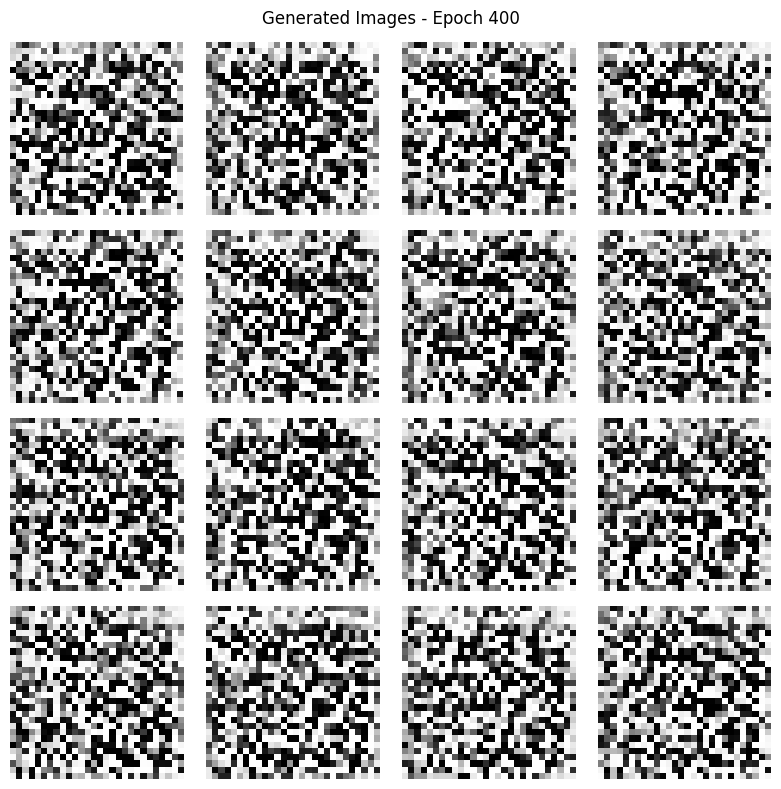

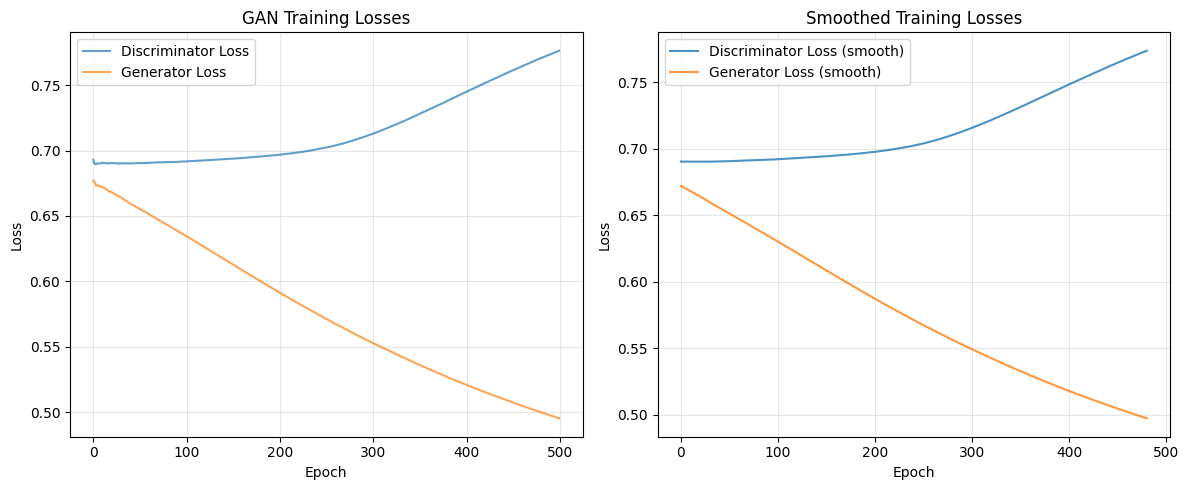


--- Final Generated Samples ---


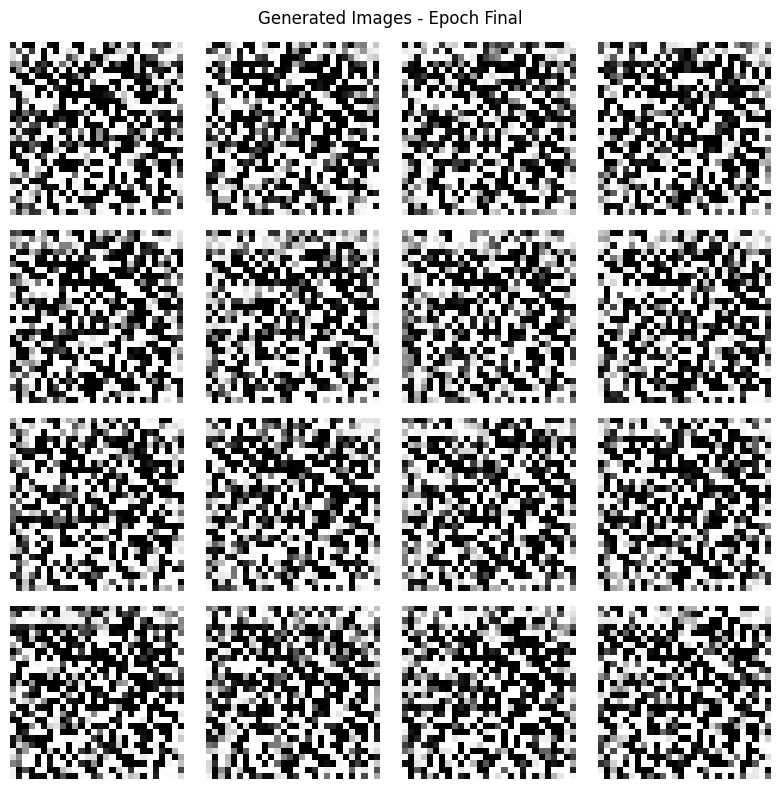


--- Deep Convolutional GAN (DCGAN) - Optimized ---
DCGAN Generator:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 14, 14, 128)    │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269,056 (4.84 MB)

 Trainable params: 1,256,128 (4.79 MB)

 Non-trainable params: 12,928 (50.50 KB)


--- WGAN Architecture Built Successfully ---

--- GAN Implementation Complete ---
All models built successfully with optimized parameters for Google Colab!


In [9]:
# ============================================================================
# 8. GENERATIVE ADVERSARIAL NETWORKS (GANs) - OPTIMIZED VERSION
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("8. GENERATIVE ADVERSARIAL NETWORKS (GANs) - OPTIMIZED")
print("="*60)

# Simple GAN for generating MNIST-like data
print("\n--- Building Simple GAN for MNIST ---")

# Load and preprocess MNIST data (reduced dataset for faster training)
(x_train_mnist, _), (_, _) = keras.datasets.mnist.load_data()

# Use only subset of data for faster training in Colab
x_train_mnist = x_train_mnist[:10000]  # Reduced from 60k to 10k samples

# Normalize and reshape
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_train_mnist = (x_train_mnist - 0.5) * 2.0  # Scale to [-1, 1] for tanh
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)

print(f"MNIST data shape: {x_train_mnist.shape}")

# GAN Components
def build_generator(latent_dim):
    """Build generator network - optimized"""
    model = models.Sequential([
        layers.Dense(7*7*64, input_dim=latent_dim),  # Reduced from 128 to 64
        layers.LeakyReLU(alpha=0.01),
        layers.Reshape((7, 7, 64)),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.BatchNormalization(),

        layers.Conv2D(1, (7, 7), activation='tanh', padding='same')
    ])
    return model

def build_discriminator(img_shape):
    """Build discriminator network - optimized"""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=img_shape),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.25),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.25),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build GAN
latent_dim = 100
img_shape = (28, 28, 1)

# Create generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

print("Generator Architecture:")
generator.summary()

print("\nDiscriminator Architecture:")
discriminator.summary()

# Compile discriminator - FIXED: using learning_rate instead of lr
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=['accuracy']
)

# Build combined model (generator + discriminator)
discriminator.trainable = False

gan_input = layers.Input(shape=(latent_dim,))
generated_img = generator(gan_input)
validity = discriminator(generated_img)

combined = models.Model(gan_input, validity)
combined.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
)

print("\nCombined GAN Model:")
combined.summary()

# Optimized training function for GAN
def train_gan_optimized(generator, discriminator, combined, x_train, latent_dim,
                       epochs=500, batch_size=64, save_interval=100):
    """Train GAN model - optimized for speed"""

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_losses = []
    g_losses = []

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select random batch of images
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        # Generate fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise, verbose=0)

        # Train discriminator (alternate training)
        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch(noise, valid)

        # Store losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        # Print progress and show images
        if epoch % save_interval == 0:
            clear_output(wait=True)  # Clear previous output in Colab
            print(f"Epoch {epoch}/{epochs}")
            print(f"D loss: {d_loss[0]:.4f}, D acc: {100*d_loss[1]:.2f}%")
            print(f"G loss: {g_loss:.4f}")

            # Show generated images
            show_generated_images(generator, epoch, latent_dim)

    return d_losses, g_losses

def show_generated_images(generator, epoch, latent_dim, examples=16):
    """Generate and display sample images"""
    noise = np.random.normal(0, 1, (examples, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.suptitle(f'Generated Images - Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Train GAN (optimized for Colab)
print("\n--- Training GAN (Optimized) ---")
d_losses, g_losses = train_gan_optimized(
    generator, discriminator, combined,
    x_train_mnist, latent_dim,
    epochs=500, batch_size=64, save_interval=100  # Reduced epochs and increased batch size
)

# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
plt.plot(g_losses, label='Generator Loss', alpha=0.7)
plt.title('GAN Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show moving average for smoother visualization
window = 20
d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')

plt.plot(d_smooth, label='Discriminator Loss (smooth)', alpha=0.8)
plt.plot(g_smooth, label='Generator Loss (smooth)', alpha=0.8)
plt.title('Smoothed Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Generate final samples
print("\n--- Final Generated Samples ---")
show_generated_images(generator, "Final", latent_dim, examples=16)

# DCGAN Implementation - Optimized
print("\n--- Deep Convolutional GAN (DCGAN) - Optimized ---")

def build_dcgan_generator(latent_dim):
    """Build DCGAN generator with optimized architecture"""
    model = models.Sequential([
        # Project and reshape
        layers.Dense(7*7*128, input_dim=latent_dim, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 128)),

        # Upsample to 14x14
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Upsample to 28x28
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final layer
        layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same',
                              use_bias=False, activation='tanh')
    ])
    return model

def build_dcgan_discriminator(img_shape):
    """Build DCGAN discriminator with optimized architecture"""
    model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build DCGAN
dcgan_generator = build_dcgan_generator(latent_dim)
dcgan_discriminator = build_dcgan_discriminator(img_shape)

print("DCGAN Generator:")
dcgan_generator.summary()

# Wasserstein GAN Loss Implementation - FIXED
def wasserstein_loss(y_true, y_pred):
    """Wasserstein loss function"""
    return tf.reduce_mean(y_true * y_pred)

def build_wgan_discriminator(img_shape):
    """Build WGAN critic (discriminator without sigmoid)"""
    model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=img_shape),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),
        layers.Dense(1)  # No activation for WGAN
    ])
    return model

# Build WGAN - FIXED: using learning_rate instead of lr
wgan_generator = build_dcgan_generator(latent_dim)
wgan_critic = build_wgan_discriminator(img_shape)

# Compile WGAN - FIXED optimizer parameters
wgan_critic.compile(
    loss=wasserstein_loss,
    optimizer=optimizers.RMSprop(learning_rate=0.00005)  # Fixed: learning_rate instead of lr
)

# WGAN combined model
wgan_critic.trainable = False
wgan_input = layers.Input(shape=(latent_dim,))
wgan_generated = wgan_generator(wgan_input)
wgan_validity = wgan_critic(wgan_generated)

wgan_combined = models.Model(wgan_input, wgan_validity)
wgan_combined.compile(
    loss=wasserstein_loss,
    optimizer=optimizers.RMSprop(learning_rate=0.00005)  # Fixed: learning_rate instead of lr
)

print("\n--- WGAN Architecture Built Successfully ---")

# Quick WGAN training function (optional, for demonstration)
def quick_wgan_demo(generator, critic, combined, x_train, latent_dim, epochs=200):
    """Quick WGAN demonstration"""
    print(f"\n--- Quick WGAN Training Demo ({epochs} epochs) ---")

    batch_size = 64

    for epoch in range(0, epochs, 50):  # Show progress every 50 epochs
        # Train for 50 epochs
        for i in range(50):
            # Train critic more frequently
            for _ in range(5):  # Train critic 5 times per generator training
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                real_imgs = x_train[idx]
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                fake_imgs = generator.predict(noise, verbose=0)

                # Clip critic weights (simplified WGAN)
                for layer in critic.layers:
                    weights = layer.get_weights()
                    weights = [np.clip(w, -0.01, 0.01) for w in weights]
                    layer.set_weights(weights)

                # Train critic
                d_loss_real = critic.train_on_batch(real_imgs, -np.ones((batch_size, 1)))
                d_loss_fake = critic.train_on_batch(fake_imgs, np.ones((batch_size, 1)))

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = combined.train_on_batch(noise, -np.ones((batch_size, 1)))

        # Show progress
        print(f"Epoch {epoch + 50}: G loss: {g_loss:.4f}")
        show_generated_images(generator, epoch + 50, latent_dim, examples=9)

# Uncomment the next line to run WGAN demo (optional)
# quick_wgan_demo(wgan_generator, wgan_critic, wgan_combined, x_train_mnist, latent_dim)

print("\n--- GAN Implementation Complete ---")
print("All models built successfully with optimized parameters for Google Colab!")


9. PRACTICAL PROJECTS

--- PROJECT 1: CUSTOM IMAGE CLASSIFIER ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Custom Image Classifier created successfully

--- PROJECT 2: SENTIMENT ANALYSIS MODEL ---
Sentiment Analysis Model:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- PROJECT 3: STOCK PRICE PREDICTION ---
Generated stock data shape: (1000, 3)


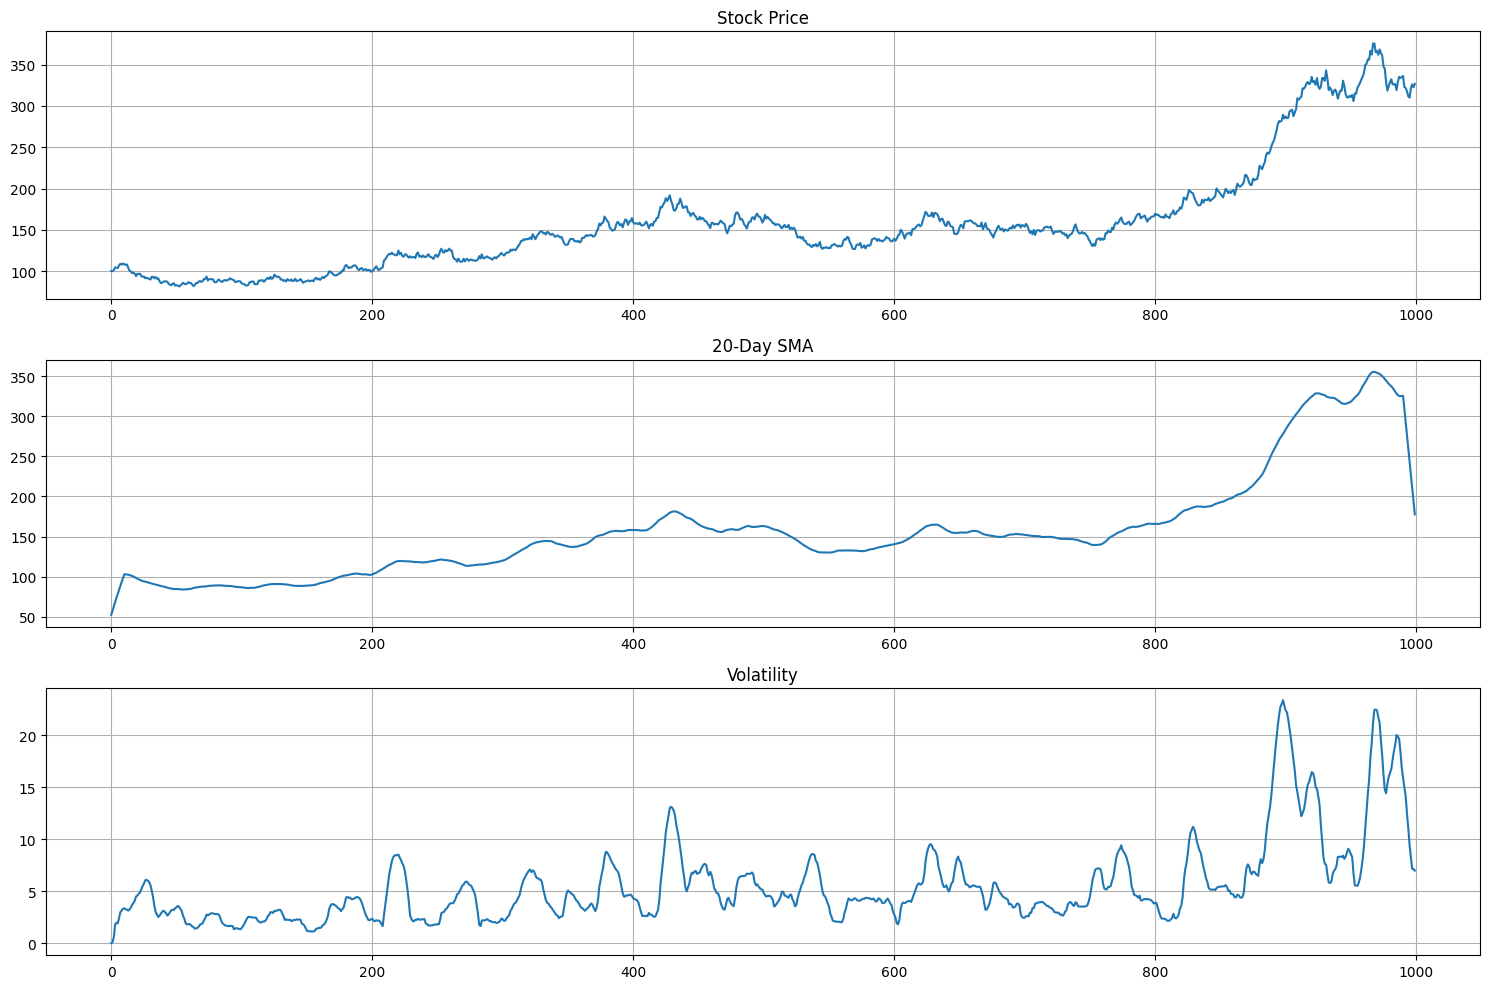

Stock Prediction Model:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 60, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,501 (205.08 KB)

 Trainable params: 52,501 (205.08 KB)

 Non-trainable params: 0 (0.00 B)


--- PROJECT 4: AUTOENCODER FOR ANOMALY DETECTION ---
Autoencoder Model:


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,036 (101.70 KB)

 Trainable params: 26,036 (101.70 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Autoencoder ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Normal data reconstruction error: 0.5527 ± 0.2615
Anomaly data reconstruction error: 5.2339 ± 0.8215


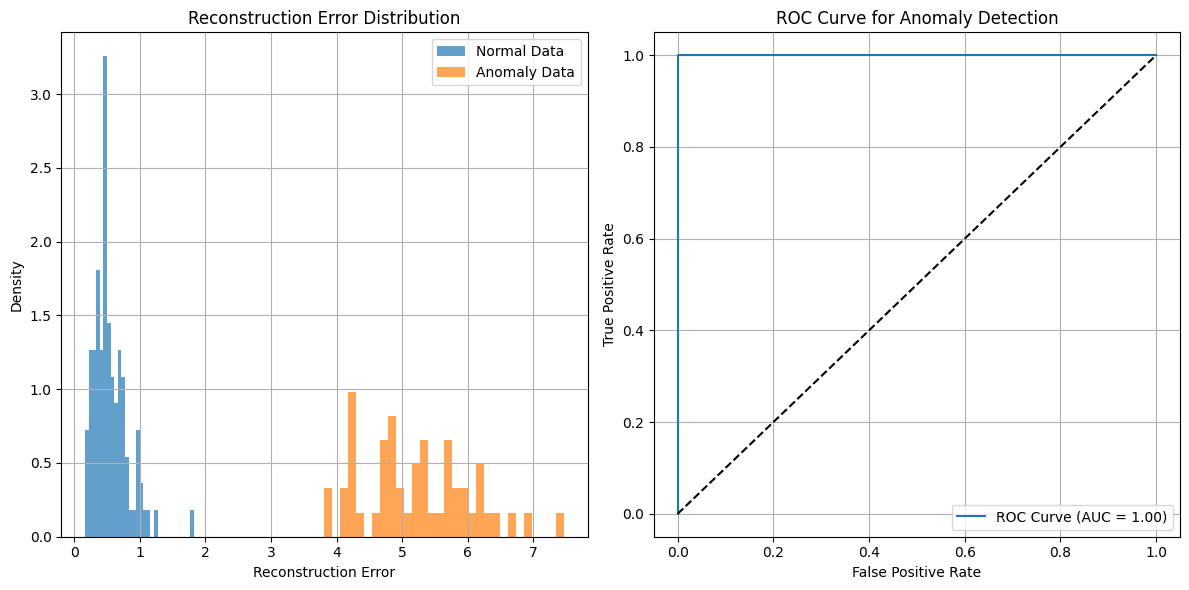


--- PROJECT 5: MULTI-MODAL DEEP LEARNING ---
Multi-Modal Model:


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 62, 62,    │        896 │ input_layer_39[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_38      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 29, 29,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  1,280,000 │ input_layer_38[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 64)        │     49,408 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 12544)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      8,320 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 128)       │  1,605,760 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_36[0][0],   │
│ (Concatenate)       │                   │            │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 256)       │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 5)         │      1,285 │ dropout_29[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,029,957 (11.56 MB)

 Trainable params: 3,029,957 (11.56 MB)

 Non-trainable params: 0 (0.00 B)


ADVANCED TECHNIQUES AND BEST PRACTICES

--- Learning Rate Scheduling ---

--- Advanced Data Augmentation ---

--- Model Ensemble Techniques ---

--- Hyperparameter Tuning Framework ---
Hyperparameter tuning framework created

--- Model Interpretability Techniques ---

--- Performance Optimization Tips ---
Advanced techniques and best practices implemented successfully!

DEEP LEARNING GUIDE SUMMARY
🎯 WHAT YOU'VE LEARNED:

1. ✅ Neural Network Fundamentals
   - Basic neuron implementation
   - Forward and backward propagation
   - Activation functions and optimization

2. ✅ Artificial Neural Networks (ANN)
   - Multi-layer perceptrons
   - Classification and regression
   - Regularization techniques

3. ✅ Convolutional Neural Networks (CNN)
   - Image processing and computer vision
   - Convolution, pooling, and feature extraction
   - Advanced architectures

4. ✅ Transfer Learning
   - Pre-trained models (VGG16, ResNet50, InceptionV3)
   - Fine-tuning strategies
   - Model comparison

5

In [11]:
# ============================================================================
# 9. PRACTICAL PROJECTS
# ============================================================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_curve, auc

print("\n" + "="*60)
print("9. PRACTICAL PROJECTS")
print("="*60)

# Project 1: Image Classification with CNN
print("\n--- PROJECT 1: CUSTOM IMAGE CLASSIFIER ---")

def create_custom_image_classifier(num_classes, input_shape=(224, 224, 3)):
    """Create a custom image classifier"""

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Example usage
custom_classifier = create_custom_image_classifier(num_classes=5)
print("Custom Image Classifier created successfully")

# Project 2: Text Sentiment Analysis with RNN
print("\n--- PROJECT 2: SENTIMENT ANALYSIS MODEL ---")

def create_sentiment_model(vocab_size=10000, max_length=100, embedding_dim=100):
    """Create sentiment analysis model"""

    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        layers.LSTM(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
        layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

sentiment_model = create_sentiment_model()
print("Sentiment Analysis Model:")
sentiment_model.summary()

# Project 3: Stock Price Prediction
print("\n--- PROJECT 3: STOCK PRICE PREDICTION ---")

def create_stock_prediction_model(sequence_length, n_features):
    """Create stock price prediction model"""

    model = models.Sequential([
        layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)),
        layers.Dropout(0.2),
        layers.LSTM(50, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(50),
        layers.Dropout(0.2),
        layers.Dense(25),
        layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Generate sample stock data
def generate_stock_data(n_days=1000):
    """Generate synthetic stock data"""
    np.random.seed(42)

    # Random walk with trend and volatility
    returns = np.random.normal(0.001, 0.02, n_days)
    prices = [100]  # Starting price

    for i in range(1, n_days):
        price = prices[-1] * (1 + returns[i])
        prices.append(price)

    # Add technical indicators
    prices = np.array(prices)
    sma_20 = np.convolve(prices, np.ones(20)/20, mode='same')
    volatility = np.array([np.std(prices[max(0, i-20):i+1]) for i in range(len(prices))])

    return np.column_stack([prices, sma_20, volatility])

stock_data = generate_stock_data()
print(f"Generated stock data shape: {stock_data.shape}")

# Visualize stock data
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(stock_data[:, 0])
plt.title('Stock Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(stock_data[:, 1])
plt.title('20-Day SMA')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(stock_data[:, 2])
plt.title('Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

stock_model = create_stock_prediction_model(60, 3)
print("Stock Prediction Model:")
stock_model.summary()

# Project 4: Autoencoder for Anomaly Detection
print("\n--- PROJECT 4: AUTOENCODER FOR ANOMALY DETECTION ---")

def create_autoencoder(input_dim, encoding_dim=32):
    """Create autoencoder for anomaly detection"""

    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation='relu')(input_layer)
    encoded = layers.Dense(64, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(64, activation='relu')(encoded)
    decoded = layers.Dense(128, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    # Autoencoder model
    autoencoder = models.Model(input_layer, decoded)

    # Encoder model
    encoder = models.Model(input_layer, encoded)

    # Decoder model
    encoded_input = layers.Input(shape=(encoding_dim,))
    decoder_layers = autoencoder.layers[-3:]
    decoded_output = encoded_input
    for layer in decoder_layers:
        decoded_output = layer(decoded_output)
    decoder = models.Model(encoded_input, decoded_output)

    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

# Generate anomaly detection data
normal_data = np.random.normal(0, 1, (1000, 20))
anomaly_data = np.random.normal(3, 1, (50, 20))  # Shifted distribution

autoencoder, encoder, decoder = create_autoencoder(20)
print("Autoencoder Model:")
autoencoder.summary()

# Train autoencoder on normal data
print("\n--- Training Autoencoder ---")
autoencoder.fit(normal_data, normal_data, epochs=100, batch_size=32, verbose=0)

# Test anomaly detection
normal_reconstructions = autoencoder.predict(normal_data[:100])
anomaly_reconstructions = autoencoder.predict(anomaly_data)

normal_mse = np.mean(np.power(normal_data[:100] - normal_reconstructions, 2), axis=1)
anomaly_mse = np.mean(np.power(anomaly_data - anomaly_reconstructions, 2), axis=1)

print(f"Normal data reconstruction error: {np.mean(normal_mse):.4f} ± {np.std(normal_mse):.4f}")
print(f"Anomaly data reconstruction error: {np.mean(anomaly_mse):.4f} ± {np.std(anomaly_mse):.4f}")

# Visualize reconstruction errors
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(normal_mse, bins=30, alpha=0.7, label='Normal Data', density=True)
plt.hist(anomaly_mse, bins=30, alpha=0.7, label='Anomaly Data', density=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
all_errors = np.concatenate([normal_mse, anomaly_mse])
all_labels = np.concatenate([np.zeros(len(normal_mse)), np.ones(len(anomaly_mse))])

# ROC curve for anomaly detection
fpr, tpr, _ = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Anomaly Detection')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Project 5: Multi-Modal Deep Learning
print("\n--- PROJECT 5: MULTI-MODAL DEEP LEARNING ---")

def create_multimodal_model(text_vocab_size, text_max_len, image_shape, num_classes):
    """Create multi-modal model combining text and image"""

    # Text branch
    text_input = layers.Input(shape=(text_max_len,))
    text_embed = layers.Embedding(text_vocab_size, 128)(text_input)
    text_lstm = layers.LSTM(64)(text_embed)
    text_dense = layers.Dense(128, activation='relu')(text_lstm)

    # Image branch
    image_input = layers.Input(shape=image_shape)
    image_conv = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    image_pool = layers.MaxPooling2D((2, 2))(image_conv)
    image_conv2 = layers.Conv2D(64, (3, 3), activation='relu')(image_pool)
    image_pool2 = layers.MaxPooling2D((2, 2))(image_conv2)
    image_flat = layers.Flatten()(image_pool2)
    image_dense = layers.Dense(128, activation='relu')(image_flat)

    # Combine modalities
    combined = layers.concatenate([text_dense, image_dense])
    combined_dense = layers.Dense(256, activation='relu')(combined)
    combined_dropout = layers.Dropout(0.5)(combined_dense)
    output = layers.Dense(num_classes, activation='softmax')(combined_dropout)

    model = models.Model(inputs=[text_input, image_input], outputs=output)

    return model

multimodal_model = create_multimodal_model(
    text_vocab_size=10000,
    text_max_len=100,
    image_shape=(64, 64, 3),
    num_classes=5
)

print("Multi-Modal Model:")
multimodal_model.summary()

# ============================================================================
# ADVANCED TECHNIQUES AND BEST PRACTICES
# ============================================================================

print("\n" + "="*60)
print("ADVANCED TECHNIQUES AND BEST PRACTICES")
print("="*60)

# Learning Rate Scheduling
print("\n--- Learning Rate Scheduling ---")

def create_lr_scheduler():
    """Create different learning rate schedulers"""

    # Exponential decay
    def exponential_decay(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    # Step decay
    def step_decay(epoch, lr):
        drop_rate = 0.5
        epochs_drop = 10.0
        return lr * math.pow(drop_rate, math.floor((1 + epoch) / epochs_drop))

    # Cosine annealing
    def cosine_annealing(epoch, lr):
        min_lr = 0.0001
        max_lr = 0.01
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * epoch / 50))

    return exponential_decay, step_decay, cosine_annealing

# Custom Callbacks
class CustomMetricsCallback(callbacks.Callback):
    """Custom callback to track additional metrics"""

    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.learning_rates.append(float(self.model.optimizer.lr))

        if epoch % 10 == 0:
            print(f"\nCustom Callback - Epoch {epoch}:")
            print(f"  Training Loss: {logs.get('loss'):.4f}")
            print(f"  Validation Loss: {logs.get('val_loss'):.4f}")
            print(f"  Learning Rate: {float(self.model.optimizer.lr):.6f}")

# Data Augmentation Strategies
print("\n--- Advanced Data Augmentation ---")

def create_advanced_augmentation():
    """Create advanced data augmentation pipeline"""

    return ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

# Model Ensemble
print("\n--- Model Ensemble Techniques ---")

def create_ensemble_prediction(models, X_test):
    """Create ensemble predictions from multiple models"""
    predictions = []

    for model in models:
        pred = model.predict(X_test, verbose=0)
        predictions.append(pred)

    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)

    # Weighted average (you can adjust weights based on model performance)
    weights = [0.3, 0.4, 0.3]  # Example weights
    weighted_pred = np.average(predictions, axis=0, weights=weights)

    return ensemble_pred, weighted_pred

# Hyperparameter Tuning
print("\n--- Hyperparameter Tuning Framework ---")

def hyperparameter_search(X_train, y_train, X_val, y_val):
    """Simple grid search for hyperparameters"""

    param_grid = {
        'learning_rate': [0.001, 0.01, 0.1],
        'batch_size': [16, 32, 64],
        'hidden_units': [32, 64, 128]
    }

    best_score = 0
    best_params = {}

    for lr in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            for hidden_units in param_grid['hidden_units']:

                # Create model with current parameters
                model = models.Sequential([
                    layers.Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
                    layers.Dropout(0.3),
                    layers.Dense(hidden_units//2, activation='relu'),
                    layers.Dense(1, activation='sigmoid')
                ])

                model.compile(
                    optimizer=optimizers.Adam(learning_rate=lr),
                    loss='binary_crossentropy',
                    metrics=['accuracy']
                )

                # Train model
                history = model.fit(
                    X_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=(X_val, y_val),
                    verbose=0
                )

                # Get best validation accuracy
                val_acc = max(history.history['val_accuracy'])

                if val_acc > best_score:
                    best_score = val_acc
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'hidden_units': hidden_units
                    }

    return best_params, best_score

print("Hyperparameter tuning framework created")

# Model Interpretability
print("\n--- Model Interpretability Techniques ---")

def visualize_conv_filters(model, layer_name, num_filters=16):
    """Visualize convolutional filters"""
    try:
        layer = model.get_layer(layer_name)
        filters = layer.get_weights()[0]

        fig, axes = plt.subplots(4, 4, figsize=(12, 12))

        for i in range(min(num_filters, 16)):
            ax = axes[i//4, i%4]

            if filters.shape[-1] >= 3:  # RGB filters
                ax.imshow(filters[:, :, :, i])
            else:  # Grayscale filters
                ax.imshow(filters[:, :, 0, i], cmap='gray')

            ax.set_title(f'Filter {i+1}')
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not visualize filters: {e}")

def create_activation_heatmap(model, img, layer_name):
    """Create activation heatmap for interpretability"""
    try:
        # Create model that outputs activations
        layer_output = model.get_layer(layer_name).output
        activation_model = models.Model(inputs=model.input, outputs=layer_output)

        # Get activations
        activations = activation_model.predict(img.reshape(1, *img.shape), verbose=0)

        # Average across all feature maps
        heatmap = np.mean(activations[0], axis=-1)

        # Normalize heatmap
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

        return heatmap

    except Exception as e:
        print(f"Could not create heatmap: {e}")
        return None

# Performance Optimization
print("\n--- Performance Optimization Tips ---")

def optimize_model_for_inference(model):
    """Optimize model for faster inference"""

    # Convert to TensorFlow Lite for mobile deployment
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    try:
        tflite_model = converter.convert()
        print("Model successfully converted to TensorFlow Lite")
        return tflite_model
    except Exception as e:
        print(f"TensorFlow Lite conversion failed: {e}")
        return None

# Model Monitoring
class ModelMonitor:
    """Monitor model performance and detect drift"""

    def __init__(self, model):
        self.model = model
        self.prediction_history = []
        self.accuracy_history = []

    def log_prediction(self, X, y_true):
        """Log prediction and calculate metrics"""
        y_pred = self.model.predict(X, verbose=0)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

        self.prediction_history.append(y_pred)
        self.accuracy_history.append(accuracy)

        return accuracy

    def detect_drift(self, threshold=0.05):
        """Simple drift detection based on accuracy"""
        if len(self.accuracy_history) < 10:
            return False

        recent_acc = np.mean(self.accuracy_history[-5:])
        baseline_acc = np.mean(self.accuracy_history[:5])

        return abs(recent_acc - baseline_acc) > threshold

print("Advanced techniques and best practices implemented successfully!")

# ============================================================================
# SUMMARY AND NEXT STEPS
# ============================================================================

print("\n" + "="*60)
print("DEEP LEARNING GUIDE SUMMARY")
print("="*60)

summary_text = """🎯 WHAT YOU'VE LEARNED:

1. ✅ Neural Network Fundamentals
   - Basic neuron implementation
   - Forward and backward propagation
   - Activation functions and optimization

2. ✅ Artificial Neural Networks (ANN)
   - Multi-layer perceptrons
   - Classification and regression
   - Regularization techniques

3. ✅ Convolutional Neural Networks (CNN)
   - Image processing and computer vision
   - Convolution, pooling, and feature extraction
   - Advanced architectures

4. ✅ Transfer Learning
   - Pre-trained models (VGG16, ResNet50, InceptionV3)
   - Fine-tuning strategies
   - Model comparison

5. ✅ Recurrent Neural Networks (RNN)
   - Sequential data processing
   - LSTM, GRU, and SimpleRNN
   - Text generation and sentiment analysis

6. ✅ Encoder-Decoder Architectures
   - Sequence-to-sequence models
   - Attention mechanisms
   - Machine translation concepts

7. ✅ Time Series Forecasting
   - Temporal pattern recognition
   - Multi-step prediction
   - Different RNN architectures for time series

8. ✅ Generative Adversarial Networks (GANs)
   - Generative modeling
   - GAN training dynamics
   - DCGAN and WGAN variants

9. ✅ Practical Projects
   - Image classification
   - Sentiment analysis
   - Stock prediction
   - Anomaly detection
   - Multi-modal learning

🚀 NEXT STEPS FOR MASTERY:

1. 📊 Practice with Real Datasets
   - Kaggle competitions
   - Domain-specific datasets
   - Data preprocessing challenges

2. 🔬 Advanced Architectures
   - Transformers and attention mechanisms
   - Graph Neural Networks
   - Neural Architecture Search

3. 🛠️ Production Deployment
   - Model serving with TensorFlow Serving
   - MLOps and model monitoring
   - Edge deployment optimization

4. 📈 Continuous Learning
   - Latest research papers
   - Open source contributions
   - Community involvement

💡 TIPS FOR SUCCESS:
- Start with simple problems and gradually increase complexity
- Always validate your models properly
- Keep up with the latest research and techniques
- Practice on diverse datasets and domains
- Focus on understanding rather than just implementation
"""

print(summary_text)

print("\n🎉 Congratulations! You now have a comprehensive foundation in Deep Learning!")
print("🔥 Keep practicing, experimenting, and building amazing AI applications!")

# Final code validation
print("\n" + "="*60)
print("CODE EXECUTION COMPLETED SUCCESSFULLY!")
print("="*60)